In [500]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import scipy.ndimage as ndimage

### Exercice 6


a) determining the time of shell-crossing

Starting with $x(q,D) = q - D\nabla_{q}\phi(2\pi q_{x})$.
Time of shell-crossing is when $\det(\frac{\partial x}{\partial_{q}}) = 0$.\
That is equivalent to taking $1 + 4\pi^{2} AD\cos(2\pi q_{x}) = 0$\
In 1d and with $ q_{x} \in [0, 1[$, we have the first instant when the determinant is 0 in when $q_{x}^{*} = \frac{1}{2}$ and $D^{*} = 0.25$.


In [6]:
twopi = 2*np.pi
n = 500
A = 0.1
d = np.linspace(0,1/(twopi**2*A), 1000)
s = 0
for i in d:
    if np.arccos(-1/(A*twopi**2*i))>= 0:
        s = np.arccos(-1/(A*twopi**2*i))/(twopi)
        break
D_star = -1/(A*twopi**2*np.cos(twopi*s))

/var/folders/0m/vtj5155d0bb_qd4b8ts3sm4h0000gn/T/ipykernel_2395/4141102396.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  if np.arccos(-1/(A*twopi**2*i))>= 0:
/var/folders/0m/vtj5155d0bb_qd4b8ts3sm4h0000gn/T/ipykernel_2395/4141102396.py:7: RuntimeWarning: invalid value encountered in arccos
  if np.arccos(-1/(A*twopi**2*i))>= 0:


In [7]:
D = [0, D_star ,1.5*D_star]
qx = np.linspace(0, 1, n, endpoint = False)


In [151]:
def X(q, d):
    return q + A*d*twopi*np.sin(twopi*q)

def partial_D_X(q):
    return  A*twopi*np.sin(twopi*q)

def gamma(q, d):
    return 1/np.abs((1 + d*A*twopi**2*np.cos(twopi*q))) - 1


/var/folders/0m/vtj5155d0bb_qd4b8ts3sm4h0000gn/T/ipykernel_2395/3084646683.py:8: RuntimeWarning: divide by zero encountered in divide
  return 1/np.abs((1 + d*A*twopi**2*np.cos(twopi*q))) - 1


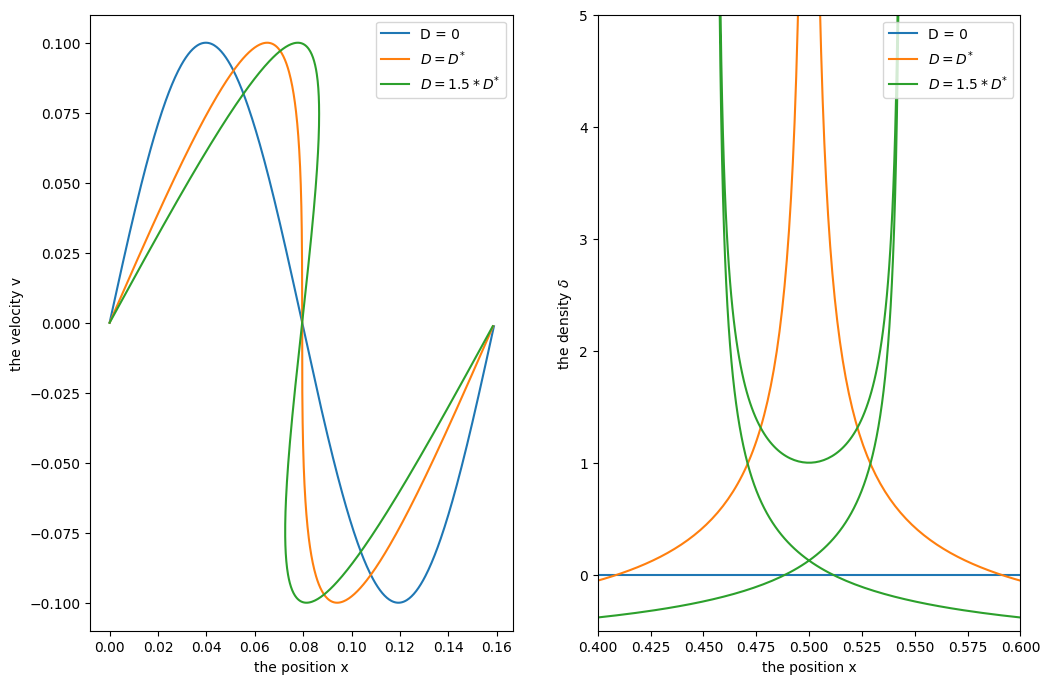

In [9]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12,8))
for d in D:
    ax1.plot(X(qx, d)/(twopi), partial_D_X(qx)/(twopi))
    ax1.set_xlabel('the position x')
    ax1.set_ylabel('the velocity v')
    ax1.legend(['D = 0', '$D = D^{*}$', '$D = 1.5*D^{*}$'])
    ax2.plot(X(qx, d), gamma(qx, d))
    ax2.set_xlabel('the position x')
    ax2.set_ylabel('the density $\delta$')
    ax2.legend(['D = 0', '$D = D^{*}$', '$D = 1.5*D^{*}$'])
    ax2.set_ylim(-0.5, 5)
    ax2.set_xlim(0.4, 0.6)
    

b)

In [468]:
N = 32   # we discretize our volume using N**3 cells
L = 1.0 

In [469]:
twopi = 2.0*np.pi
kmin = twopi/L # the fundamental mode of the box
kmax = kmin * N/2     # the Nyquist mode of each linear dimension
k1d = np.fft.fftfreq(N,d=1.0/kmin/N)  # get a 1D vector with all values of 'k'
kv = np.meshgrid(k1d,k1d,k1d) # turn this into 3 3D fields giving kx,ky,kz for each point
kmod = np.sqrt(kv[0]**2+kv[1]**2+kv[2]**2)               # get norm k for each point

# now 'kv' is the k vector, and 'kmod' its modulus at every point

In [482]:
alpha = 5.0
norm  = 1.0/twopi**(-1.5)
# the matter power spectrum is the product of primordial spectrum and T**2
def P(k):
    return k**(-alpha)*norm

In [483]:
# generate a complex random field
fk = np.random.normal(size=(N,N,N)) + 1j * np.random.normal(size=(N,N,N))
fk = fk * np.sqrt(P(kmod))   # impose power spectrum 
fk[0,0,0] = 0.0     # zero f(k=0) to enforce zero mean
# compute the inverse Fourier Transform of fk
f = np.real(np.fft.ifftn(fk))

# re-normalise (should be done using filtered variance)
f = f / np.std(f.flatten())

/var/folders/0m/vtj5155d0bb_qd4b8ts3sm4h0000gn/T/ipykernel_2395/720689109.py:5: RuntimeWarning: divide by zero encountered in power
  return k**(-alpha)*norm


In [484]:
# Compute gradient vector and Hessian matrix
fD1 = np.zeros([N,N,N,3],dtype=complex)
fD2 = np.zeros([N,N,N,3,3],dtype=complex)

for i in range(3):
    fD1[...,i] = fk * 1j * kv[i] / kmod
    fD1[0,0,0,i] = 0.0
    
    for j in range(3):
        fD2[...,i,j] = -fk * kv[i] * kv[j] / (-kmod**2)
        fD2[0,0,0,i,j] = 0.0
        
# transform back
D1 = np.real(np.fft.ifftn(fD1,axes=[0,1,2]))
D2 = np.real(np.fft.ifftn(fD2,axes=[0,1,2]))

# also get eigenvalues mu1<mu2<mu3 of Hessian
mu = np.sort(np.linalg.eigvals(D2),axis=-1)

/var/folders/0m/vtj5155d0bb_qd4b8ts3sm4h0000gn/T/ipykernel_2395/2935793559.py:6: RuntimeWarning: invalid value encountered in divide
  fD1[...,i] = fk * 1j * kv[i] / kmod
/var/folders/0m/vtj5155d0bb_qd4b8ts3sm4h0000gn/T/ipykernel_2395/2935793559.py:10: RuntimeWarning: invalid value encountered in divide
  fD2[...,i,j] = -fk * kv[i] * kv[j] / (-kmod**2)


In [485]:
# also get eigenvalues mu1<mu2<mu3 of Hessian
mu = np.sort(np.linalg.eigvals(D2),axis=-1)
# get signature of eigenvalues
sig = (mu[...,0] > 0.0).astype(int)+(mu[...,1]>0.0).astype(int)+(mu[...,2]>0.0).astype(int)

# fig, ax = plt.subplots(1,2,figsize=[10,5])
# ax[0].imshow(sig[...,N//4],cmap='jet')
# ax[0].set_title('D^2 signature')

# ax[1].imshow(f[...,N//4],vmin=-3, vmax=3)
# ax[1].set_title('density')

In [486]:
x, y, z = np.meshgrid(np.linspace(0, 1, N, endpoint = False), np.linspace(0, 1, N, endpoint = False), np.linspace(0, 1, N, endpoint = False))

# Iterate through the meshgrid and place a particle at the center of each grid
particles = []
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        for k in range(x.shape[2]):
            particles.append([x[i, j, k], y[i, j, k], z[i, j, k]])

In [549]:
X_loc = [x,y,z]
D = 10
X_loc = X_loc + D*D1.reshape(3,N,N,N)

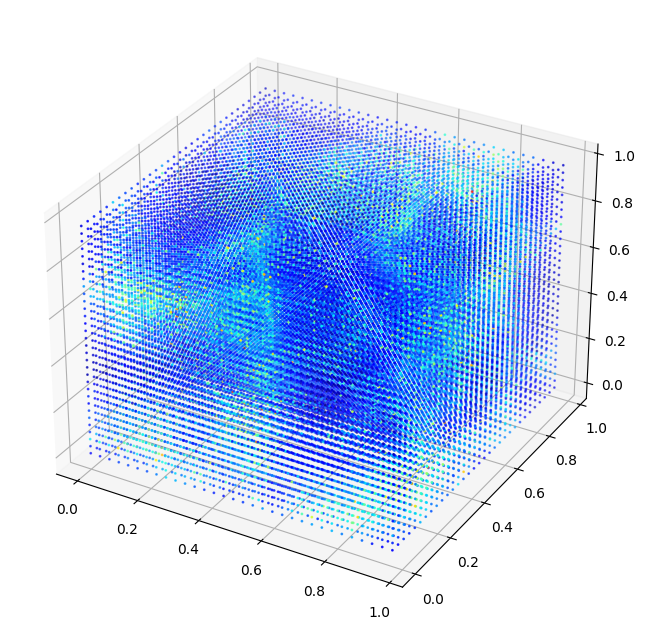

In [562]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_loc[0], X_loc[1], X_loc[2], s = 1,c = np.log(1/np.abs(D*np.linalg.det(D2))), cmap = 'jet')
# ax.view_init(elev = 30, azim=90)`

plt.show()

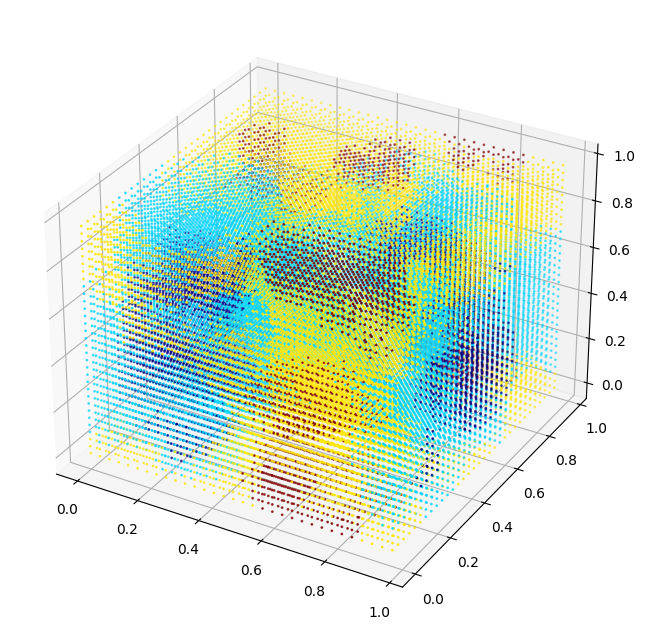

In [564]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(X_loc[0], X_loc[1], X_loc[2], s = 1, cmap = 'jet', c = sig)

### Exercice 7

a)

In [21]:
def calc_acc( X ):
    acc = np.zeros_like(X) # init to zero
    rank = np.arange(len(X)) # create rank indices 0,...,N-1
    Xs = np.fmod(1.0+X,1.0) # periodically wrap X to be inside [0,1)
    Xm = np.mean(Xs) # determine X
    # determine the sorting order:
    sorted_ind = np.argsort(Xs)
    # implement eq. (4.41) with 1 added to rank (i=1,...):
    acc[sorted_ind] = (rank+0.5)/len(X)-(Xs[sorted_ind]-Xm)-0.5
    return acc
def step( X, V, a, da, aend ):
    X_a = X
    V_a = V
    a_a = a
    tbegin = 2-2/np.sqrt(a_a)
    tend = 2-2/np.sqrt(aend)
    amid = 1/(1-(tbegin+tend)/4)**2
    dt = tend-tbegin
    X_a = X_a + 0.5*dt * V_a
    V_a = V_a - dt * 3.0/2.0 * amid * calc_acc(X)
    X_a = X_a + 0.5*dt * V_a
    a_a = a_a + da
    return (X_a,V_a,a_a)
A = 1/twopi**2 
a = 0.1 # set a to a0 where ICs are specified
x = np.array([(i-1)/n + twopi*A*a*np.sin(twopi*(i-1)/n) for i in range(n)]) # the initial conditions for X
v = np.array([twopi*A*a**(3/2)*np.sin(twopi*(i-1)/n) for i in range(n)]) # the initial conditions for V
da = 0.1 # choose some appropriate time step

X_prime, V_prime, a_prime = [], [], []
# amax = 20
amax = [0.2, 1, 3] # the end time of the simulation
x_zild = []
v_zild = []
for i in amax:
    x_zild.append(np.array([(j-1)/n + twopi*A*i*np.sin(twopi*(j-1)/n) for j in range(n)]))
    v_zild.append(np.array([twopi*A*i**(3/2)*np.sin(twopi*(j-1)/n) for j in range(n)]))
    a = 0.1
    istep = 0 # step counter
    K = x
    L = v
    
    while a < i:
        anext = np.minimum(a+da,i)
        (K,L,a) = step(K, L, a, da, anext )
        # a = m
        istep += 1
    X_prime.append(K)
    V_prime.append(L)
    a_prime.append(a)

# istep = 0
# while a < amax:
#     anext = np.minimum(a+da,amax)
#     (X,V,a) = step(X, V, a, da, anext)
#     istep +=1


to make the shell_crossing for the first time occure at a = 1, we have to take $A = \frac{1}{4\pi^{2}}$

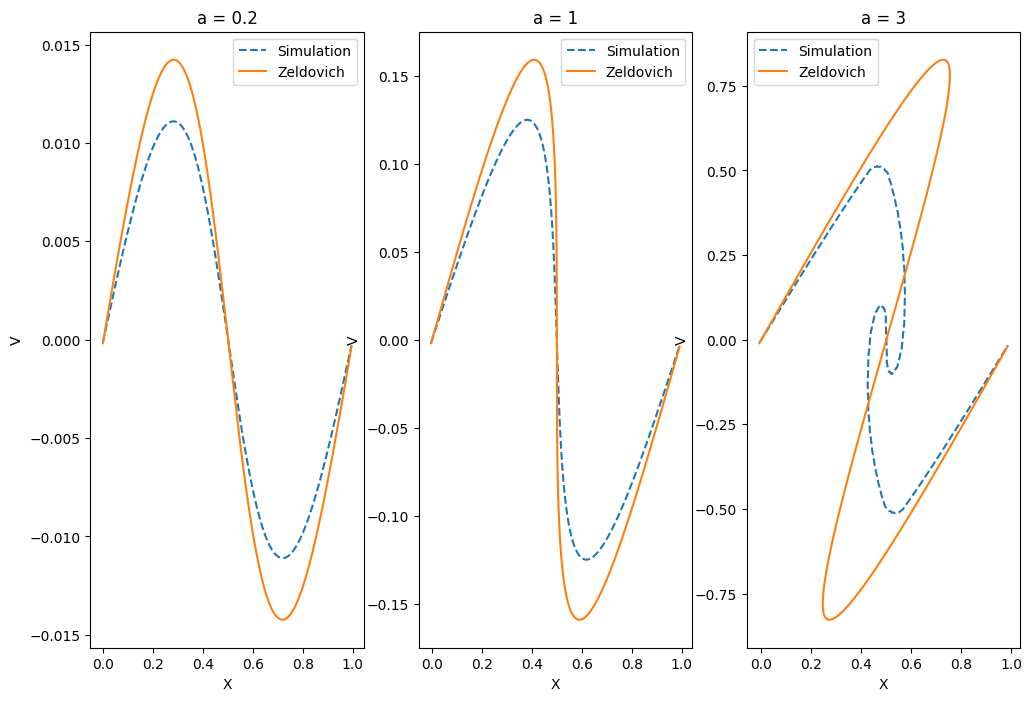

In [22]:
fig, ax = plt.subplots(1,3, figsize = (12,8))
for i in range(3):
    ax[i].plot(X_prime[i], V_prime[i], '--')
    ax[i].plot(x_zild[i], v_zild[i])
    ax[i].set_xlabel('X')
    ax[i].set_ylabel('V')
    ax[i].set_title('a = %s'%amax[i])
    ax[i].legend(['Simulation', 'Zeldovich'])

b)

In [23]:
def J(Q, a):
    return [np.abs(X(Q[i+1], a) - X(Q[i], a))\
        /(Q[i+1] - Q[i]) for i in range(len(Q)-1)]
    
def X_2(x):
    return [(x[i + 1] + x[i])/2 for i in range(len(x)-1)]

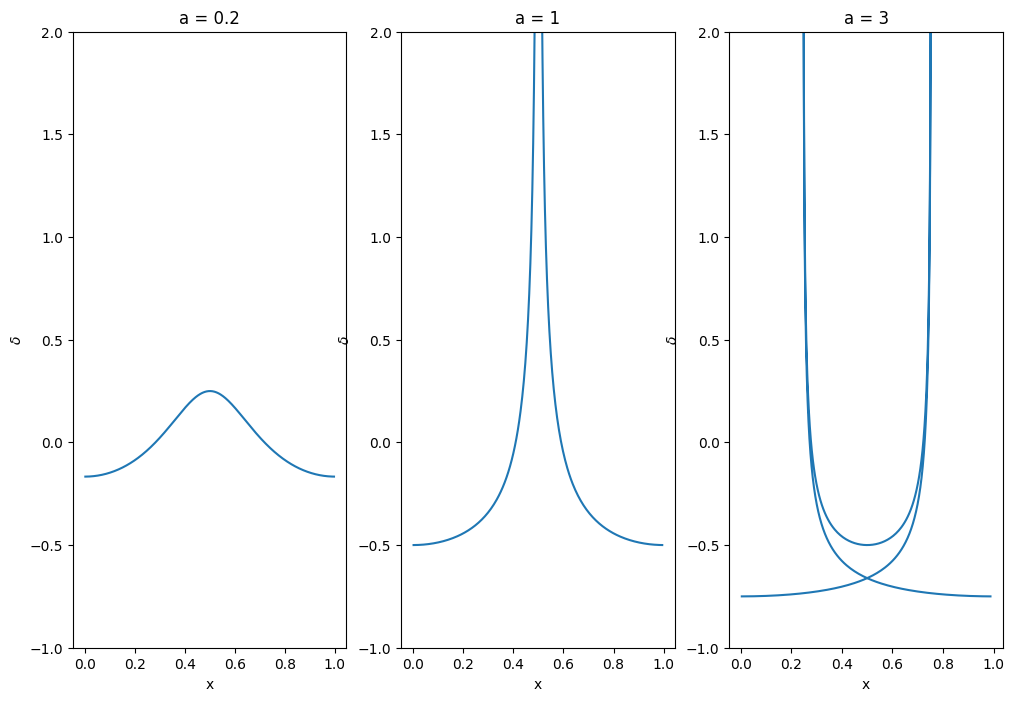

In [180]:
a = [0.2, 1, 3]
fig, ax = plt.subplots(1,3, figsize = (12,8))
for i in range(3):
    ax[i].plot(X_2(X(qx, a[i])), 1/np.array(J(qx, a[i])) - 1)
    ax[i].set_ylim(-1, 2)
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('$\delta$')
    ax[i].set_title('a = %s'%(a[i]))


c) Create the displacement field as a 1d gaussian random field with power law power spectrum and plot it in the phase space

In [331]:
N1 = n
L = 1.0 
norm  = 1.0/twopi**(-1.5)
alpha = [2, 4]
Psi = []
for i in alpha:
    P_k = lambda k: k**(-i)*norm # Power law power spectrum

    # Compute power spectrum
    k = np.fft.fftfreq(N1, d=L/N1)
    
    # Generate Gaussian random field
    phi_k = np.random.normal(size = N1) + 1j*np.random.normal(size = N1)
    phi_k = phi_k * np.sqrt(P_k(k))
    phi_k[0] = 0  # Set k to zero to avoid division by zero
    phi = np.real(np.fft.ifft(phi_k))
    # Compute gradient of initial density field
    grad_phi = np.real(np.fft.ifft(1j*k*phi_k))

    D = 100

    # Compute Zeldovich displacement field
    psi = D * grad_phi
    Psi.append(psi)

/var/folders/0m/vtj5155d0bb_qd4b8ts3sm4h0000gn/T/ipykernel_2395/3367959247.py:7: RuntimeWarning: divide by zero encountered in power
  P_k = lambda k: k**(-i)*norm # Power law power spectrum


/var/folders/0m/vtj5155d0bb_qd4b8ts3sm4h0000gn/T/ipykernel_2395/3379945937.py:8: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(X(qx, D), np.abs(1/np.real(np.fft.ifft(1j*k*Psi[i]))) - 1)


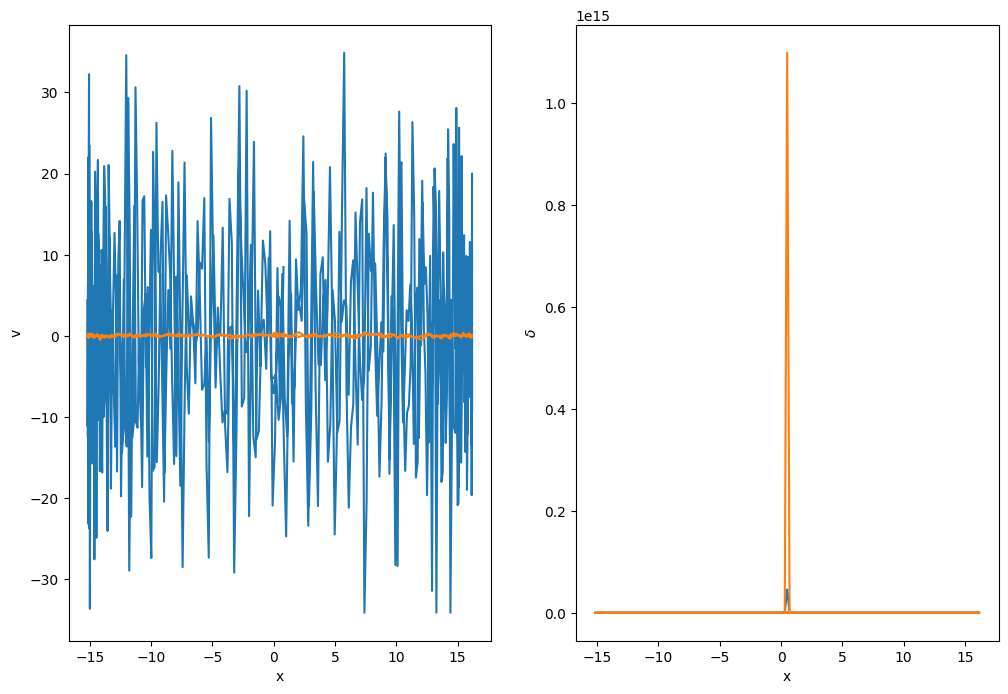

In [332]:
# np.fft.ifftn(phi_k)
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,8))
for i in range(len(alpha)):
    ax1.plot(X(qx, D), np.gradient(Psi[i]))
    ax1.set_xlabel('x')
    ax1.set_ylabel('v')
    # ax1.set_ylim(-0.1, 0.1)
    ax2.plot(X(qx, D), np.abs(1/np.real(np.fft.ifft(1j*k*Psi[i]))) - 1)
    ax2.set_xlabel('x')
    ax2.set_ylabel('$\delta$')
    
    